In [3]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr, probplot, shapiro, kstest, anderson

from statsmodels.formula.api import ols
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
origin = pd.read_excel("3사분위수_데이터.xlsx")
df = origin.drop("Unnamed: 0", axis=1)
df.head()

,price,carat,cut,color,clarity,x,y,z,depth,table
0,2757,0.70,Ideal,E,SI1,5.70,5.72,3.57,62.5,57.0
1,2757,0.86,Fair,E,SI2,6.45,6.33,3.52,55.1,69.0
2,2757,0.70,Ideal,G,VS2,5.70,5.67,3.50,61.6,56.0
3,2759,0.71,Very Good,E,VS2,5.68,5.73,3.56,62.4,57.0
4,2759,0.78,Very Good,G,SI2,5.81,5.85,3.72,63.8,56.0


In [5]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.
    Parameters
    ---------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.
    Returns
    ------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """
    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터(VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue
        # VIF계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p: (
            "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        )

        # 한 변수에 대한 보고 정보 추가
        variables.append(
            {
                "종속변수": yname,
                "독립변수": name,
                "B": v[1].strip(),
                "표준오차": v[2].strip(),
                "Beta": float(fit.params[name])
                * (data[name].std(ddof=1) / data[yname].std(ddof=1)),  # 표준화 회귀계수
                "t": "%s%s" % (v[3].strip(), stars(p)),  # t-통계량(+별표)
                "p-value": p,
                "공차": 1 / vif,
                "vif": vif,
            }
        )

    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for i in [0, 2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0, n, 2):
                key = item[i].strip()[:-1]
                value = item[i + 1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = f"𝑅({result_dict['R-squared']}), 𝑅^2({result_dict['Adj. R-squared']}), 𝐹({result_dict['F-statistic']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})"
    # 모형 보고 문장 구성
    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    model_report = tpl % (
        rdf["종속변수"][0],
        ",".join(list(rdf["독립변수"])),
        (
            "유의하다"
            if float(result_dict["Prob (F-statistic)"]) <= 0.05
            else "유의하지 않다"
        ),
        result_dict["Df Model"],
        result_dict["Df Residuals"],
        result_dict["F-statistic"],
        "<=" if float(result_dict["Prob (F-statistic)"]) <= 0.05 else ">",
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(
            s
            % (
                row["독립변수"],
                row["B"],
                "<=" if float(row["p-value"]) < 0.05 else ">",
                row["종속변수"],
                "유의미한" if float(row["p-value"]) < 0.05 else "유의하지 않은",
            )
        )
        return rdf, result_report, model_report, variable_reports

In [6]:
mydata = df
yname = "price"

mydata1 = mydata.drop(["cut", "color", "clarity"], axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 1차 회귀분석 ===")
display(rdf)

=== 1차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1946.6252,143.683,0.396070,13.548***,0.000,0.003910,255.742845
1,price,x,-726.4866,68.915,-0.346030,-10.542***,0.000,0.000150,6654.912465
2,price,y,1373.0672,73.655,0.630631,18.642***,0.000,0.000166,6037.686501
3,price,z,262.1352,59.605,0.081898,4.398***,0.000,0.000537,1862.848148
4,price,depth,-10.4435,5.652,-0.020124,-1.848,0.065,0.000954,1048.729956
5,price,table,-16.0639,2.275,-0.043664,-7.060***,0.000,0.001704,586.964672


vif값이 가장 높은 x제거하고 다시 분석

In [7]:
mydata = df
yname = "price"

mydata1 = mydata.drop(["x", "cut", "color", "clarity"], axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 2차 회귀분석 ===")
display(rdf)

=== 2차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1453.0945,136.396,0.295654,10.653***,0.000,0.003928,254.563716
1,price,y,1005.3187,65.135,0.461729,15.434***,0.000,0.000648,1542.456651
2,price,z,9.8239,54.812,0.003069,0.179,0.858,0.000593,1686.834004
3,price,depth,12.8672,5.222,0.024794,2.464*,0.014,0.000983,1017.340719
4,price,table,-17.1062,2.282,-0.046496,-7.495***,0.000,0.001807,553.435859


vif값이 가장 높은 z를 제거하고 다시분석

In [8]:
mydata = df
yname = "price"

mydata1 = mydata.drop(["z", "x", "cut", "color", "clarity"], axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 3차 회귀분석 ===")
display(rdf)

=== 3차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1456.2459,135.253,0.296295,10.767***,0.000,0.005948,168.120392
1,price,y,1010.0124,59.636,0.463885,16.936***,0.000,0.000735,1361.026505
2,price,depth,13.4065,4.268,0.025833,3.141**,0.002,0.002013,496.887068
3,price,table,-17.1148,2.282,-0.046520,-7.500***,0.000,0.001873,533.992185


vif값이 가장 높은 y를 제거하고 다시 분석

In [9]:
mydata = df
yname = "price"

mydata1 = mydata.drop(["y", "z", "x", "cut", "color", "clarity"], axis=1)
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("=== 4차 회귀분석 ===")
display(rdf)

=== 4차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,3694.2077,29.155,0.751642,126.711***,0.0,0.034093,29.331300
1,price,depth,-36.0178,3.147,-0.069403,-11.444***,0.0,0.002844,351.668719
2,price,table,-25.1729,2.255,-0.068423,-11.162***,0.0,0.002779,359.895143


vif값이 가장 높은 table을 제외하고 다시 분석

In [10]:
mydata = df
yname = "price"

mydata1 = mydata.filter(["price", "carat", "depth"])
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata1)
print("===5차 회귀분석")
display(rdf)

===5차 회귀분석


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,3631.4652,28.739,0.738876,126.362***,0.0,0.035249,28.36981
1,price,depth,-26.1518,3.035,-0.050392,-8.618***,0.0,0.035249,28.36981


carat과 depth 모두 vif값은 동일하나, carat의 t 값이 더 크기에 depth을 제거 후 다시 분석

In [11]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.filter(["price", "carat"])
x = mydata1.drop(yname, axis=1)
y = mydata1[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print("=== 6차 회귀분석 ===")
display(tbl1)

=== 6차 회귀분석 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                 1.581e+04
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:41:21   Log-Likelihood:            -1.0473e+05
No. Observations:               13461   AIC:                         2.095e+05
Df Residuals:                   13459   BIC:                         2.095e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        508.7249     26.547     19.163      0.000     456.690     560.760
carat       3612.1279     28.729    125.732      0.000    3555.815    3668.440
==============================================================================
Omnibus:                      102.270   Durbin-Watson:                   0.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.946
Skew:                          -0.059   Prob(JB):                     6.14e-34
Kurtosis:                       3.509   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

명목형 변수들을 다시 넣은 후 회귀분석

In [12]:
mydata = df
yname = "price"
# mydata1=mydata.copy()

mydata1 = mydata.filter(["price", "carat", "cut", "color", "clarity"])
mydata2 = pd.get_dummies(mydata1, drop_first=True)
mydata2 = mydata2.astype(float)
x = mydata2.drop(yname, axis=1)
y = mydata2[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, mydata2)
print("=== 7차 회귀분석 ===")
display(rdf)

=== 7차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,6194.6032,30.355,1.260385,204.070***,0.0,0.038367,26.064318
1,price,cut_Good,341.8515,18.411,0.130845,18.567***,0.0,0.315969,3.164869
2,price,cut_Ideal,593.3180,16.939,0.323916,35.026***,0.0,0.154517,6.471774
3,price,cut_Premium,373.7509,16.926,0.191953,22.082***,0.0,0.177683,5.628014
4,price,cut_Very Good,460.0712,17.075,0.233518,26.944***,0.0,0.184513,5.419684
5,price,color_E,-167.7263,12.597,-0.076014,-13.315***,0.0,0.415748,2.405304
6,price,color_F,-255.3630,12.576,-0.116898,-20.306***,0.0,0.402062,2.487180
7,price,color_G,-426.5867,13.081,-0.185612,-32.610***,0.0,0.418563,2.389129
8,price,color_H,-533.6424,13.440,-0.235285,-39.707***,0.0,0.384734,2.599197
9,price,color_I,-921.5333,15.276,-0.334971,-60.324***,0.0,0.477198,2.095566


📕 선형성 검정
RESET F-statistic: 1097.7389
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


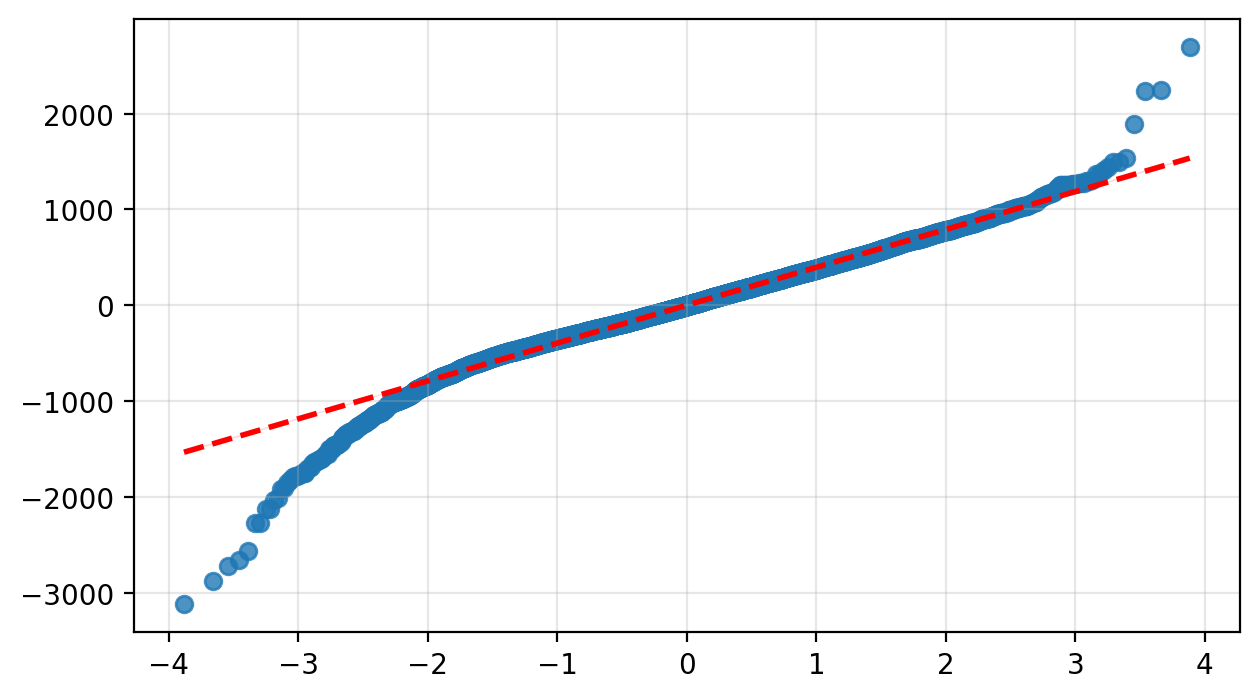

루트 1MSE 구간에 포함된 잔차 비율: 72.31%
루트 2MSE 구간에 포함된 잔차 비율: 95.51%
루트 3MSE 구간에 포함된 잔차 비율: 99.08%


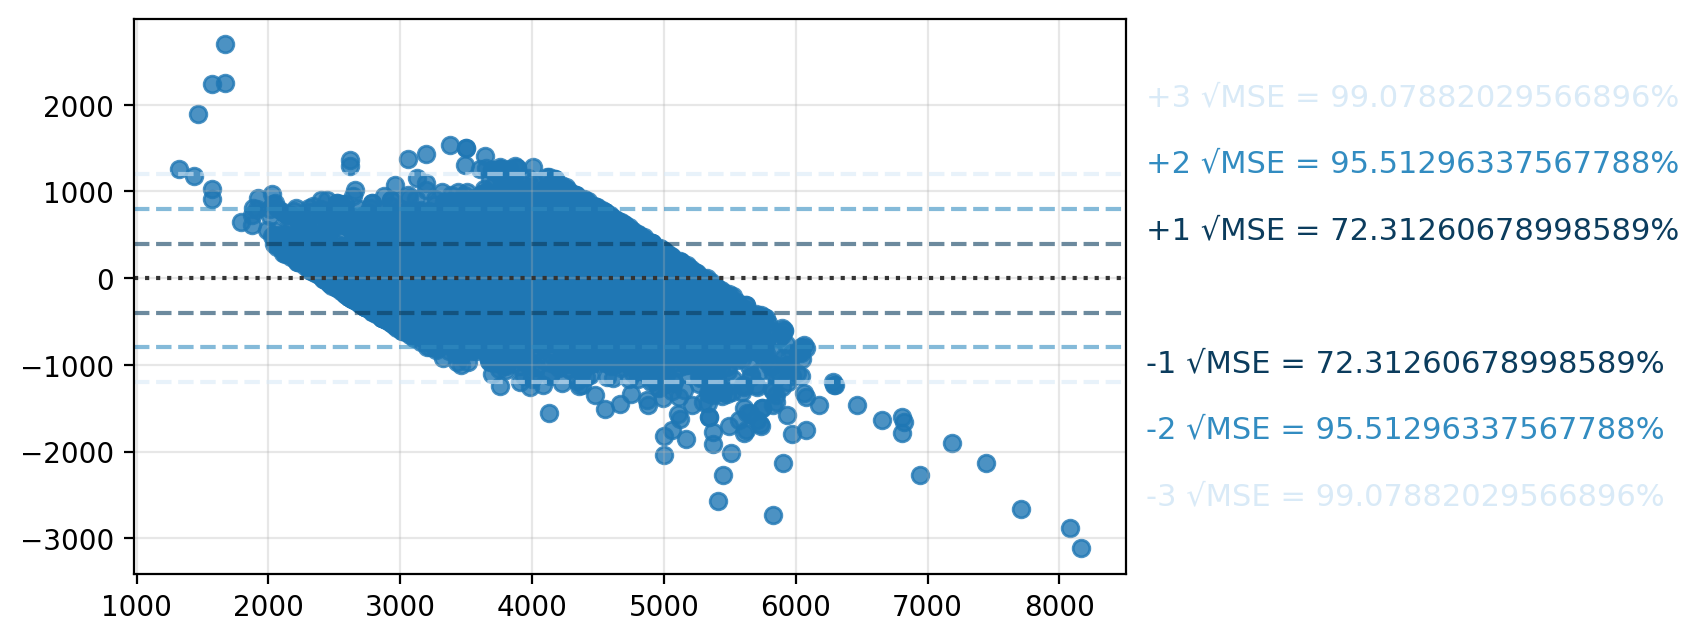

🎯 잔차의 정규성, 등분산성, 독립성 검정
Anderson-Darling statistic: 20.2107, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)
Breusch-Pagan statistic: 90.300, p-value = 0.000
이분산성 존재(등분산 아님)
Durbin-Watson=1.412
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)
🎓 최종 결과 보고
price에 대하여 carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,13442) = 2676., p <= 0.05).
carat의 회귀계수는 6194.6032(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.


In [13]:
# 잔차 검정
print("=" * 50)
print("📕 선형성 검정")
print("=" * 50)
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

(x, y), _ = probplot(fit.resid)
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.regplot(x=x, y=y, line_kws={"color": "red", "linestyle": "--", "linewidth": 2})
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

rr = fit.resid
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
r1 = rr[(rr > -mse_root) & (rr < mse_root)].count() / rr.count() * 100
r2 = rr[(rr > -2 * mse_root) & (rr < 2 * mse_root)].count() / rr.count() * 100
r3 = rr[(rr > -3 * mse_root) & (rr < 3 * mse_root)].count() / rr.count() * 100
mse_r = [r1, r2, r3]
print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%")
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.residplot(x=fit.fittedvalues, y=fit.resid)
ax.grid(True, alpha=0.3)
for i, c in enumerate(colors):
    k = i + 1
    y_pos = k * mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
    ax.text(
        x=1.02,
        y=0.5 + 0.12 * k,
        s=f"+{k} √MSE = {mse_r[i]}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
    ax.text(
        x=1.02,
        y=0.5 - 0.12 * k,
        s=f"-{k} √MSE = {mse_r[i]}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
plt.show()
plt.close()

# 잔차의 정규성, 등분산성, 독립성 검정
print("=" * 50)
print("🎯 잔차의 정규성, 등분산성, 독립성 검정")
print("=" * 50)
if len(origin) < 5000:
    method = "Shapiro-Wilk"
    s, p = shapiro(fit.resid)
    print(f"{method} statistic: {s:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist="norm")
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5
print(
    "정규성 가정 위배 가능성이 있음 (5% 유의수준)"
    if violated
    else "정규성 가정 위배 근거 없음 (5% 유의수준)"
)

names = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=["value"])
p_bp = bp.loc["F p-value", "value"]
print(
    f"Breusch-Pagan statistic: {bp.loc['F Statistic', 'value']:.3f}, p-value = {p_bp:.3f}"
)
print(f"{'이분산성 존재(등분산 아님)' if p_bp<=0.05 else '등분산성 만족'}")

dw = durbin_watson(fit.resid)
if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(-)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
print(f"Durbin-Watson={dw:.3f}\n{interpretation}")

# 최종 결과 보고
print("=" * 50)
print("🎓 최종 결과 보고")
print("=" * 50)
print(m)
print("\n".join(v))

p-value 값이 0.05보다 작기 때문에 잔차검정 진행

In [14]:
r

'𝑅(0.782), 𝑅^2(0.782), 𝐹(2676.), 유의확률(0.00), Durbin-Watson(1.412)'

1. 연속형 변수만 선택
2. VIF 계산
4. 남은 연속형 고정
5. 명목형 더미화
6. 결합
7. 회귀
명목형 변수를 더미화할 경우 다중공선성 진단이 복잡해질 수 있어,
연속형 변수에 대해 먼저 VIF를 통해 구조적 공선성을 점검한 후
안정화된 모형에 명목형 변수를 추가하였다.